# QML Project

```
AUTHORS
Charlie BROSSE  
Guillaume CARRIERE  
Marius DUBOSC
```

L'objectif du projet et de reproduire les circuits et les résultats obtenus dans le papier "Polyadic Quantum Classifier" (https://arxiv.org/abs/2007.14044)

In [1]:
!pip3 install qiskit --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import qiskit
from scipy.special import erfinv
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
import time
from qiskit.providers.ibmq.managed import IBMQJobManager

qs = qiskit.Aer.get_backend('qasm_simulator')

# Useful functions

## Preprocessing functions

These functions correspond to the data encoding functions from the original paper.

In [3]:
def standardise(x):
    return (x - np.mean(x)) / np.std(x)

def rescaleFeature(x, alpha, q):
    return (1-alpha/2) * (np.pi/q) * standardise(x)

## Circuit functions

This is a function to construct a basic psi gate, as described in the paper.

In [4]:
def psiGate(qc, param, bit):
    qc.rx(np.pi/2, bit)
    qc.rz(param, bit)
    qc.rx(np.pi/2, bit)

# Quantum Classifier Class

This is the loss function described in the paper. Only relevant bitstrings are taken into account.

In [5]:
def logSoftmax(label, job_results, bitstrings, nshots) :
    if label in job_results :
        e = np.exp(job_results[label] / nshots)
    else :
        e = 1
        
    s = 0
    for bitstring in bitstrings :
        if bitstring in job_results :
            s += np.exp(job_results[bitstring] / nshots)
        else :
            s += 1 
            
    return -np.log(e / s)


This is our main class which we will use to train an predict. By default we will use COBYLA and our previously defined loss to train.

In [6]:
class QuantumClassifier:

    def __init__(self, circuit_builder, bitstrings, theta_size, loss_function = logSoftmax, optimizer_method = "COBYLA"):
        self.circuit_builder = circuit_builder
        self.circuit=None
        self.bitstrings = bitstrings
        self.theta_size = theta_size
        self.loss_function = loss_function
        self.optimizer_method = optimizer_method
        self.theta = None
        self.nshots = 100
        
    
    # Training functions
    def executeJob(self, circuit):
        job = qiskit.execute(circuit, shots=self.nshots, backend=qs)
        return  job.result().get_counts()
    
    def build_circuit(self, theta, X, y):
        omega = X
        self.circuit = self.circuit_builder(theta, omega)
        return self.circuit

    def runCircuit(self, theta, X, y):#, backend=None):
        self.build_circuit(theta, X, y)
        job_results = self.executeJob(self.circuit)
        label = y
        
        # if backend is not None:
        #     mapped_circuit = qiskit.transpile(self.circuit, backend=backend)
        #     qobj = qiskit.assemble(mapped_circuit, backend=backend, shots=self.nshots)
        #     job = backend.run(qobj)
        #     while(job.status().name != 'DONE'):
        #         time.sleep(0.1)
        #     ID = job.job_id()
        #     job = backend.retrieve_job(ID)
        #     job_results = job.result().get_counts()
        return self.loss_function(label, job_results, self.bitstrings, self.nshots)
        
        
    def lossBatch(self, theta, X, y, backend=None):
    
        total_loss = 0

        batch = list(zip(X, y))

        if backend is None:
            for X_el, y_el in zip(X, y) :
                total_loss += self.runCircuit(theta, X_el, y_el)
        else:
            circuit_list=[self.build_circuit(theta,X_el, y_el) for (X_el, y_el) in zip(X, y)]
            circs = qiskit.transpile(circuit_list, backend=backend)
            job_manager = IBMQJobManager()
            job_set = job_manager.run(circs, backend=backend, nam='iris')
            while(job_set.statuses()[0].name != 'DONE'):
                time.sleep(0.1)
                
            results = job_set.results()
            for i in range(len(y)):
                total_loss+=self.loss_function(y[i], results.get_counts(i), self.bitstrings, self.nshots)

        total_loss /= len(y)
        print("loss: " + str(total_loss))
        return total_loss
        
    def fit(self, X, y, nshots=100, maxiter=20, theta=None, backend=None):
        
        if theta is not None:
            self.theta = theta
            
        if self.theta is None:
            self.theta = np.random.uniform(0, 2 * np.pi, self.theta_size)            
            
        self.nshots = nshots

        opt = sp.optimize.minimize(
            fun=lambda params : self.lossBatch(params, X, y, backend),
            x0=self.theta,
            method=self.optimizer_method,
            options={'maxiter': maxiter}
        )
        
        self.theta = opt.x
        
        return opt
    
    # Testing functions
    def argmaxJobResults(self, job_results):
        max_label_value = None
        max_label = None
    
        for label in job_results :
            if label in self.bitstrings and (max_label_value is None or job_results[label] >= max_label_value) :
                max_label = label
                max_label_value = job_results[label]
        return max_label
    
    def predict(self, X, theta=None, nshots=100):
        
        if theta is not None:
            self.theta = theta
            
        self.nshots = nshots
        
        y_pred = []
        
        for omega in X :    
            self.circuit = self.circuit_builder(self.theta, omega)
            job_results = self.executeJob(self.circuit)
            y_pred.append(self.argmaxJobResults(job_results))

        return y_pred

    def compute_accuracy(self, y_pred, y) :
        correct = 0

        for y_pred_el, y_el in zip(y_pred, y) :
            if y_pred_el == y_el :
                correct += 1
        
        return correct / len(y)

# I - IRIS

## Construct dataset

### Import dataset

In [7]:
df_iris = pd.read_csv("iris.data")
df_iris

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### Preprocess

Preprocessing consists in computing the encoding function of the paper. We will use a fixed q value of 3 and alpha value of 1/10 as done in the paper.

In [8]:
alpha = 0.1
q = 3

attributes = df_iris.columns[:-1]

for x in attributes:
    df_iris[x] = rescaleFeature(df_iris[x], alpha, q)

df_iris

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,Iris-setosa
1,-1.137116,-0.124313,-1.334348,-1.306199,Iris-setosa
2,-1.378201,0.336104,-1.390920,-1.306199,Iris-setosa
3,-1.498743,0.105896,-1.277776,-1.306199,Iris-setosa
4,-1.016574,1.256938,-1.334348,-1.306199,Iris-setosa
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,Iris-virginica
146,0.550477,-1.275354,0.702249,0.917304,Iris-virginica
147,0.791562,-0.124313,0.815393,1.048098,Iris-virginica
148,0.429934,0.796521,0.928537,1.440481,Iris-virginica


We will attribute each class to the bistrings 00, 01 and 10. Thus, 11 will remain unused.

In [9]:
diconvert = {
    "Iris-setosa" : "00",
    "Iris-versicolor" : "01",
    "Iris-virginica" : "10"
}

df_iris = df_iris.replace({"class": diconvert})
df_iris

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,00
1,-1.137116,-0.124313,-1.334348,-1.306199,00
2,-1.378201,0.336104,-1.390920,-1.306199,00
3,-1.498743,0.105896,-1.277776,-1.306199,00
4,-1.016574,1.256938,-1.334348,-1.306199,00
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,10
146,0.550477,-1.275354,0.702249,0.917304,10
147,0.791562,-0.124313,0.815393,1.048098,10
148,0.429934,0.796521,0.928537,1.440481,10


In [10]:
X_iris = df_iris[attributes].values
y_iris = df_iris["class"].values

### Split

We will use a training size of 90 samples and a test size of 60 samples as done in the paper.

In [11]:
train_size = 90
test_size = 60

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=test_size, train_size=train_size, stratify=y_iris)

## Circuit

In [12]:
def irisCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    iris_circuit = qiskit.QuantumCircuit(2)
    for i in range(4):
        if i : iris_circuit.cz(0, 1)
        psiGate(iris_circuit, omega[(2*i) % 4], 0)
        psiGate(iris_circuit, omega[(2*i+1) % 4], 1)
        
        iris_circuit.cz(0, 1)
        
        psiGate(iris_circuit, theta[(2*i)], 0)
        psiGate(iris_circuit, theta[(2*i+1)], 1)
        
    qc.append(iris_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

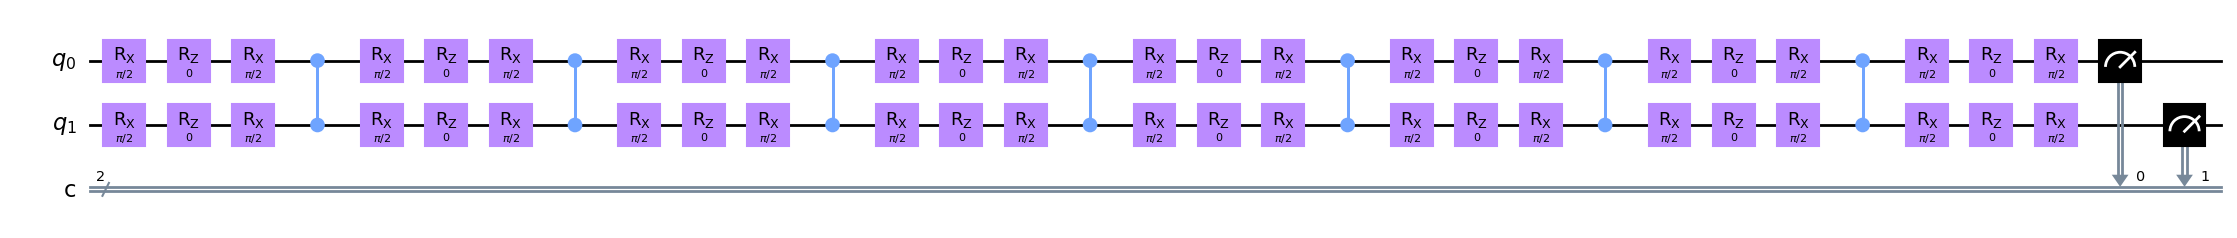

In [13]:
irisCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [14]:
iris_classifier = QuantumClassifier(irisCircuit, ['00', '01', '10'], 8)

In [15]:
opt_iris = iris_classifier.fit(X_train_iris, y_train_iris, nshots=250, maxiter=20)

loss: 1.1967238664736461
loss: 1.2015648452988157
loss: 1.1949883367340821
loss: 1.1629170367248878
loss: 1.1203749500088764
loss: 1.1709312319880394
loss: 1.1714489028614217
loss: 1.1193281259437702
loss: 1.0841621641337795
loss: 1.068788519998829
loss: 1.0336985936633505
loss: 1.0496605684651814
loss: 1.0237512388380021
loss: 1.0987710658435605
loss: 0.9887841525691403
loss: 0.9723025454835843
loss: 0.9865755006568361
loss: 1.0160552576068498
loss: 1.0140428846448926
loss: 1.0019121261840607


In [16]:
opt_iris = iris_classifier.fit(X_train_iris, y_train_iris, nshots=500, maxiter=30)

loss: 0.9715883730080195
loss: 0.9932708136836145
loss: 1.056440015415381
loss: 0.9981752712524201
loss: 0.9640626470051029
loss: 0.9672214893967078
loss: 1.0039690552318703
loss: 1.1006180085076673
loss: 1.0391930406121648
loss: 0.8870566838066531
loss: 0.930377531422052
loss: 1.0347087460648894
loss: 0.8757577021226859
loss: 0.9087392883963457
loss: 0.8558226913762139
loss: 0.8810262807997532
loss: 0.8044113831154988
loss: 0.8016832362475935
loss: 0.8015404672511329
loss: 0.8328908966745527
loss: 0.7907257854901366
loss: 0.8216334054122071
loss: 0.790157287656535
loss: 0.8085233663547259
loss: 0.7966022297470442
loss: 0.798696674556693
loss: 0.7913376715771056
loss: 0.7964823826371417
loss: 0.7915989449996876
loss: 0.7868515099547881


In [17]:
opt_iris = iris_classifier.fit(X_train_iris, y_train_iris, nshots=750, maxiter=70)

loss: 0.7867753270840214
loss: 0.8882880086745115
loss: 0.8996908743330058
loss: 0.9127234276168731
loss: 0.8595669382959159
loss: 0.8633443817253397
loss: 0.8824114102412852
loss: 0.9132697716007755
loss: 0.9023560486896557
loss: 0.7790072756248958
loss: 0.7950336430320778
loss: 0.7784669606038321
loss: 0.8067798700535929
loss: 0.8008705233555277
loss: 0.7942889365030593
loss: 0.7946646030686029
loss: 0.8175860662305591
loss: 0.7966501338057091
loss: 0.7775729781116537
loss: 0.7719540171048007
loss: 0.7807872746768764
loss: 0.7723661980412777
loss: 0.7791908046184061
loss: 0.7743358437789952
loss: 0.7732848212893464
loss: 0.7760579697358025
loss: 0.7779587205734615
loss: 0.7759093991969647
loss: 0.7743582506760986
loss: 0.7729627172978432
loss: 0.7723458462502091
loss: 0.7741582356691556
loss: 0.7753258223039532
loss: 0.7765538257992898
loss: 0.7733394640857317
loss: 0.7758032625655891
loss: 0.7734608386026938
loss: 0.7717061707324707
loss: 0.7744127897151434
loss: 0.7739834229493522


## Compute results

In [18]:
y_pred_iris = iris_classifier.predict(X_train_iris)
iris_classifier.compute_accuracy(y_pred_iris, y_train_iris)

0.8888888888888888

In [19]:
y_pred_iris = iris_classifier.predict(X_test_iris)
iris_classifier.compute_accuracy(y_pred_iris, y_test_iris)

0.8833333333333333

We obtain a precision of 88,3%, which is pretty good.

# II - Gaussian XOR

## Construct dataset

### Generate dataset

The training dataset is generated by sampling points from 2D gaussian distributions centered around key points. These key points will be on the cartesian axes. Points from the x-axis will have label 0 and points from the y-axis will have label 1.

The testing dataset will simply be the whole space.

In [106]:
import numpy as np
import math

In [107]:
def generate_gaussian_point(x, y) :
    pick_x = np.random.normal(loc=x, scale = 0.5)
    pick_y = np.random.normal(loc=y, scale = 0.5)
    return [pick_x, pick_y]

In [108]:
center1 = (-np.pi / 2, 0)
center2 = (np.pi / 2, 0)
center3 = (0, -np.pi / 2)
center4 = (0, np.pi / 2)

centers = [center1, center2, center3, center4]


In [109]:
X_train_xor = []
y_train_xor = []

for i in range(20) :
    X_train_xor.append(generate_gaussian_point(*center1))
    y_train_xor.append(0)
    
    X_train_xor.append(generate_gaussian_point(*center2))
    y_train_xor.append(0)
    
    X_train_xor.append(generate_gaussian_point(*center3))
    y_train_xor.append(1)
    
    X_train_xor.append(generate_gaussian_point(*center4))
    y_train_xor.append(1)
    
X_train_xor = np.array(X_train_xor)
y_train_xor = np.array(y_train_xor)

In [110]:
lin = np.linspace(-np.pi, np.pi, num = 50)
X_test_xor = np.array([[x, y] for x in lin for y in lin])

y_test_xor = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_test_xor]

(-3.141592653589793, 3.141592653589793)

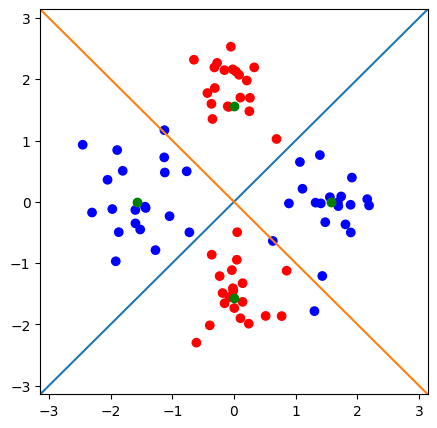

In [111]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5,5]

c = ["blue" if el==0 else "red" for el in y_train_xor]

plt.scatter(X_train_xor[:, 0], X_train_xor[:, 1], color=c)

x,y = zip(*centers)
plt.scatter(x, y, color='green')



x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

### Preprocess

We will attribute each class to the bistrings 00 and 10. Thus, 01 and 11 will remain unused.

In [112]:
diconvert = {
    0 : "00",
    1 : "10",
}

new_y_train_xor = [diconvert[x] for x in y_train_xor]
new_y_test_xor = [diconvert[x] for x in y_test_xor]

y_train_xor = new_y_train_xor
y_test_xor = new_y_test_xor

y_train_xor[:10]

['00', '00', '10', '10', '00', '00', '10', '10', '00', '00']

## Circuit

In [113]:
def xorCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    xor_circuit = qiskit.QuantumCircuit(2)
    
    psiGate(xor_circuit, omega[0], 0)
    psiGate(xor_circuit, omega[1], 1)
    
    for i in range(2):
        xor_circuit.cz(0, 1)
        psiGate(xor_circuit, theta[2*i], 0)
        psiGate(xor_circuit, theta[2*i+1], 1)
        
    
    qc.append(xor_circuit, range(2))
    qc.measure(range(2), range(2))
    return qc

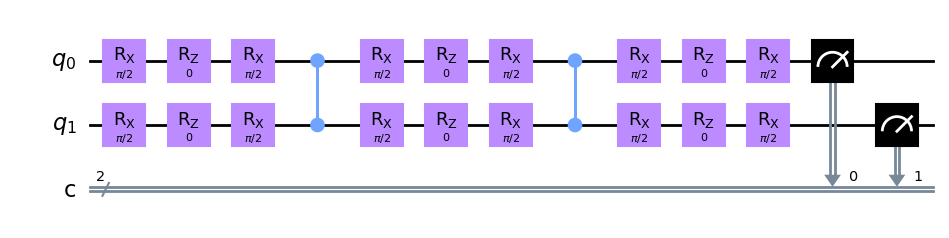

In [114]:
xorCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [115]:
xor_classifier = QuantumClassifier(xorCircuit, ['00', '10'], 4)

In [116]:
xor_opt = xor_classifier.fit(X_train_xor, y_train_xor, nshots=250, maxiter=80)
xor_opt

loss: 0.7213456028491645
loss: 0.716560138309579
loss: 0.6594954808801858
loss: 0.6339452763594107
loss: 0.599477957838993
loss: 0.6659511481752506
loss: 0.592534413209985
loss: 0.5808000481913962
loss: 0.5983191707896711
loss: 0.5759695541986872
loss: 0.5563977102199333
loss: 0.5943419955880296
loss: 0.5244452641196553
loss: 0.5066535958249381
loss: 0.4959340800466087
loss: 0.5036794310706293
loss: 0.5056418268018255
loss: 0.5101431714725545
loss: 0.49581812626137534
loss: 0.4933983047522828
loss: 0.49451424574160835
loss: 0.49048659183771
loss: 0.49424476080950575
loss: 0.49671909312675117
loss: 0.4912044099862548
loss: 0.49450694923998045
loss: 0.4934156279988725
loss: 0.49374019445706424
loss: 0.49517935191967205
loss: 0.492851297480013
loss: 0.49101283670778634
loss: 0.4932060745804989
loss: 0.4929059806986138
loss: 0.49359460593136184
loss: 0.4946132424980199
loss: 0.4935529830059352
loss: 0.494888940464498
loss: 0.4949699844480085
loss: 0.49033065964599604
loss: 0.49206770136913

     fun: 0.495519795764645
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 58
  status: 1
 success: True
       x: array([7.8553357 , 6.10667164, 7.87674292, 3.13669887])

## Compute results

In [117]:
y_pred_xor = xor_classifier.predict(X_train_xor)
xor_classifier.compute_accuracy(y_pred_xor, y_train_xor)

0.9875

In [118]:
y_pred_xor = xor_classifier.predict(X_test_xor)

(-3.141592653589793, 3.141592653589793)

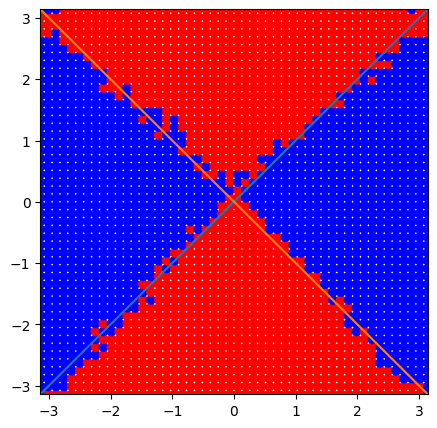

In [119]:
plt.rcParams['figure.figsize'] = [5,5]


c = ["blue" if el=="00" else "red" for el in y_pred_xor]
plt.scatter(X_test_xor[:, 0], X_test_xor[:, 1], color=c)

x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [120]:
xor_classifier.compute_accuracy(y_pred_xor, y_test_xor)

0.9472

## Compare with GaussianNB

In [121]:
from sklearn.naive_bayes import GaussianNB

In [122]:
gaussianNb = GaussianNB()

y_train_bayes = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_train_xor]

gaussianNb.fit(X_train_xor, y_train_bayes)

y_test_bayes = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_test_xor]

score = gaussianNb.score(X_test_xor, y_test_bayes)

In [123]:
score

0.9468

We obtained a precision of 94,7%, on par with the Bayes classifier's precision of 94.7%.

# III - Skin segmentation

## Construct dataset

### Import dataset

In [38]:
df_skin = pd.read_csv("Skin_NonSkin.txt", sep='\t', header=None)
df_skin

,0,1,2,3
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1
...,...,...,...,...
245052,163,162,112,2
245053,163,162,112,2
245054,163,162,112,2
245055,163,162,112,2


### Preprocess

In [39]:
alpha = 0.1
q = 3

attributes = df_skin.columns[:-1]

for x in attributes:
    df_skin[x] = rescaleFeature(df_skin[x], alpha, q)

df_skin

,0,1,2,3
0,-0.816021,-0.788476,-0.002429,1
1,-0.832001,-0.805073,-0.016139,1
2,-0.847981,-0.821670,-0.029849,1
3,-0.879941,-0.854863,-0.057269,1
4,-0.879941,-0.854863,-0.057269,1
...,...,...,...,...
245052,0.606191,0.489488,-0.153241,2
245053,0.606191,0.489488,-0.153241,2
245054,0.606191,0.489488,-0.153241,2
245055,0.606191,0.489488,-0.153241,2


We will attribute each class to the bistrings 000, 111. Every other bitstring will remain unused.

In [40]:
diconvert = {
    1 : "000",
    2 : "111"
}

df_skin = df_skin.replace({3: diconvert})
df_skin

,0,1,2,3
0,-0.816021,-0.788476,-0.002429,000
1,-0.832001,-0.805073,-0.016139,000
2,-0.847981,-0.821670,-0.029849,000
3,-0.879941,-0.854863,-0.057269,000
4,-0.879941,-0.854863,-0.057269,000
...,...,...,...,...
245052,0.606191,0.489488,-0.153241,111
245053,0.606191,0.489488,-0.153241,111
245054,0.606191,0.489488,-0.153241,111
245055,0.606191,0.489488,-0.153241,111


In [41]:
X_skin = df_skin[attributes].values
y_skin = df_skin[3].values

### Split

We will use a training size of 600 samples and a test size of 400 samples as done in the paper.

In [42]:
train_size = 600
test_size = 400

X_train_skin, X_test_skin, y_train_skin, y_test_skin = train_test_split(X_skin, y_skin, test_size=test_size, train_size=train_size, stratify=y_skin)

## Circuit

In [43]:
def skinSegCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(3, 3)
    
    skin_seg_circuit = qiskit.QuantumCircuit(3)
    psiGate(skin_seg_circuit, omega[0], 0)
    psiGate(skin_seg_circuit, omega[1], 1)
    psiGate(skin_seg_circuit, omega[2], 2)
    
    skin_seg_circuit.cz(0, 2)
    
    psiGate(skin_seg_circuit, theta[0], 0)
    psiGate(skin_seg_circuit, theta[1], 2)
    
    skin_seg_circuit.cz(0, 1)
    
    psiGate(skin_seg_circuit, theta[2], 0)
    psiGate(skin_seg_circuit, theta[3], 1)
    
    skin_seg_circuit.cz(1, 2)
    
    psiGate(skin_seg_circuit, theta[4], 1)
    psiGate(skin_seg_circuit, theta[5], 2)
    
    qc.append(skin_seg_circuit, range(3))
    qc.measure(range(3), range(3))
    
    return qc

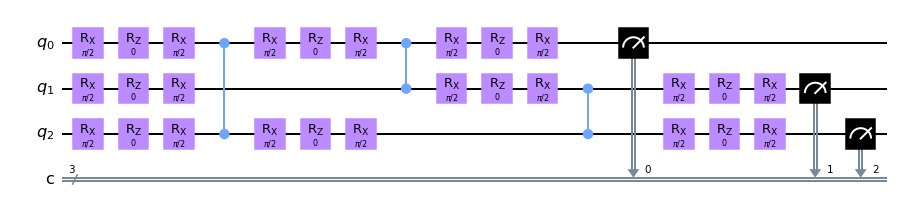

In [44]:
skinSegCircuit(np.zeros(6), np.zeros(3)).decompose().draw("mpl", fold=40)

## Train

We will use COBYLA as optimizer for this training. BFGS was used in the original paper instead, but without exact gradients this optimizer would require a very high number of shots to be efficient which would make the training too slow.

In [45]:
skin_classifier = QuantumClassifier(skinSegCircuit, ['000', '111'], 6, optimizer_method = "COBYLA")

In [46]:
opt_skin = skin_classifier.fit(X_train_skin, y_train_skin, nshots=250, maxiter=60)
opt_skin

loss: 0.6701361485099194
loss: 0.6482730147870641
loss: 0.5829088211264652
loss: 0.6309382330952783
loss: 0.6395877818963921
loss: 0.5903789543382211
loss: 0.6262598320391334
loss: 0.5764247744457908
loss: 0.5679844543346729
loss: 0.5642782923318688
loss: 0.5669398653145312
loss: 0.572713512602962
loss: 0.5691537577214733
loss: 0.571046981009535
loss: 0.5772067696496066
loss: 0.5595190344687692
loss: 0.5685152913180402
loss: 0.561653108088007
loss: 0.5682708880674517
loss: 0.5597626013703754
loss: 0.5595769625534134
loss: 0.5624875364496943
loss: 0.5601247000952102
loss: 0.5592298039554486
loss: 0.5585982535574996
loss: 0.5613000945852242
loss: 0.5594929419046305
loss: 0.5578073083580053
loss: 0.5576594412255238
loss: 0.5578505407434711
loss: 0.5568443171432278
loss: 0.5571327459411247
loss: 0.5573131273021399
loss: 0.5593087722191082
loss: 0.5583451699242923
loss: 0.5580916510439434
loss: 0.5582757272242604
loss: 0.5568193218627963
loss: 0.5578139245526358
loss: 0.557346251262718
loss

     fun: 0.5563209222016805
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 60
  status: 2
 success: False
       x: array([3.77551162, 1.76634907, 1.84893081, 0.42331581, 6.36559731,
       1.21957303])

## Compute results

In [47]:
y_pred_skin = skin_classifier.predict(X_train_skin)
skin_classifier.compute_accuracy(y_pred_skin, y_train_skin)

0.7633333333333333

In [48]:
y_pred_skin = skin_classifier.predict(X_test_skin)
skin_classifier.compute_accuracy(y_pred_skin, y_test_skin)

0.765

We obtain a precision of 76,5%. This is not bad but it could be improved by using BFGS as in the paper.

# IV - Synthetic dataset with 4 classes

## Construct dataset

### Generate dataset

We generate the dataset with sklearn, with only 2 informative features, 1 cluster per class and 4 classes.

In [38]:
from sklearn.datasets import make_classification

X_synth, y_synth = make_classification(n_samples=5000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=4)

### Preprocess

In [39]:
alpha = 0.1
q = 3


X_synth[:, 0] = rescaleFeature(X_synth[:, 0], alpha, q)
X_synth[:, 1] = rescaleFeature(X_synth[:, 1], alpha, q)

X_synth[:10]

array([[-1.13485074,  0.73598807],
       [ 1.72751524,  0.86289636],
       [-0.80719852,  0.70549979],
       [ 1.72659796, -1.31617907],
       [-0.67268606, -2.28454995],
       [ 1.19107119,  1.41312104],
       [-0.97042303,  0.86880267],
       [ 0.81759542, -0.96795413],
       [-0.93103325, -1.92154602],
       [ 0.31942468, -0.29665426]])

We will attribute each class to the bistrings 00, 01, 10 and 11. No bitstring is unused.

In [40]:
new_y_synth = []

diconvert = {
    0 : "00",
    1 : "01",
    2 : '10',
    3 : '11'
}

for el in y_synth:
    new_y_synth.append(diconvert[el])

y_synth = new_y_synth

y_synth[:10]

['01', '11', '10', '01', '00', '11', '10', '01', '00', '01']

### Split

We will use a train/test ratio of 60%/40% as done in the paper.

In [41]:
train_size = 0.6
test_size = 0.4

X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(X_synth, y_synth, test_size=test_size, train_size=train_size, stratify=y_synth)

## Circuit

In [42]:
def syntheticCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)

    synthetic_circuit = qiskit.QuantumCircuit(2)
    for i in range(2):
        if i : synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, omega[0], 0)
        psiGate(synthetic_circuit, omega[1], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i)], 0)
        psiGate(synthetic_circuit, theta[(6*i+1)], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, omega[0], 0)
        psiGate(synthetic_circuit, omega[1], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i+2)], 0)
        psiGate(synthetic_circuit, theta[(6*i+3)], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i+4)], 0)
        psiGate(synthetic_circuit, theta[(6*i+5)], 1)
    
    qc.append(synthetic_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

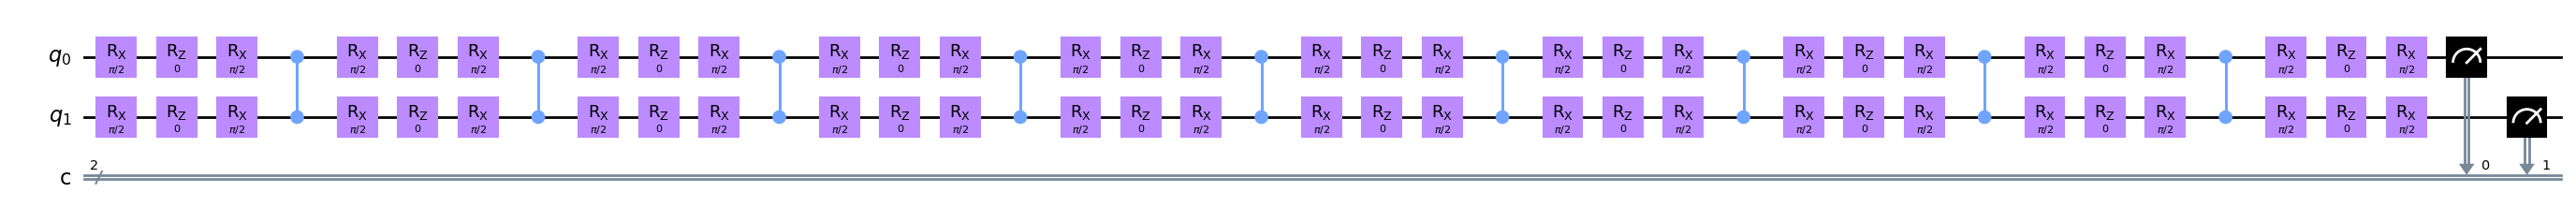

In [43]:
syntheticCircuit(np.zeros(12), np.zeros(2)).decompose().draw("mpl", fold=50)

## Train

We will use COBYLA as optimizer for this training. As for the skin dataset, BFGS would be better but would require too many shots.

In [44]:
synthetic_classifier = QuantumClassifier(syntheticCircuit, ['00', '01', '10', '11'], 12, optimizer_method = "COBYLA")

In [45]:
opt_synth = synthetic_classifier.fit(X_train_synth, y_train_synth, nshots=250, maxiter=60)
opt_synth

loss: 1.3976800791310704


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

## Compute results

In [ ]:
y_pred_synth = synthetic_classifier.predict(X_train_synth)
synthetic_classifier.compute_accuracy(y_pred_synth, y_train_synth)

In [ ]:
y_pred_synth = synthetic_classifier.predict(X_test_synth)
synthetic_classifier.compute_accuracy(y_pred_synth, y_test_synth)

We obtain 67,1%, which is not bad. As for the skin dataset, performance could be improved by using BFGS.

# V - Run on IBM Quantum Computer

In [111]:
TOKEN = "a9e80916023230fb39159420e5dd02f5b990b0b0b6de16364350b822082c4c8b2fefa2195d742c878f71f8d7771c103c2204729cffbf56145670d539c15e9dda"
qiskit.IBMQ.save_account(TOKEN, overwrite=True) 
provider = qiskit.IBMQ.load_account()
backend = qiskit.providers.ibmq.least_busy(provider.backends())
# backend = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2023-01-20 21:52:21,522: Credentials are already in use. The existing account in the session will be replaced.


## IRIS

In [163]:
iris_classifier = QuantumClassifier(irisCircuit, ['00', '01', '10'], 8)


In [164]:
opt_iris = iris_classifier.fit(X_train_iris, y_train_iris, nshots=250, maxiter=20, backend=backend)

loss: 4.251313164485948
loss: 2.8896047651923658
loss: 4.257516165983766
loss: 4.804427558562162
loss: 4.036089449958713
loss: 2.0910323144621015
loss: 3.186667598693079
loss: 2.4149131942956665
loss: 1.6302902117206979
loss: 3.443870333125019
loss: 1.1969088301900697
loss: 1.3991346551422161
loss: 1.3470176232400297
loss: 1.6368378255853586
loss: 0.742849940906313
loss: 1.1355607697739092
loss: 0.9086087311890021
loss: 0.7560336157394774
loss: 0.807268024551553
loss: 0.3616025167024722


In [129]:
mapped_circuit = qiskit.transpile(iris_classifier.circuit, backend=backend)
qobj = qiskit.assemble(mapped_circuit, backend=backend, shots=1024)

In [39]:
# execute the circuit
job = backend.run(qobj)


In [48]:
status = job.status()
status


<JobStatus.DONE: 'job has successfully run'>

In [49]:
status.name

'DONE'

In [42]:
ID = job.job_id()

In [34]:
job = backend.retrieve_job(ID)

In [35]:
result = job.result()

In [36]:
counts = result.get_counts()

In [37]:
counts

{'00': 141, '01': 370, '10': 509, '11': 4}